In [16]:
import scipy.io
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import scipy.stats as st
from sklearn.decomposition import FastICA

In [17]:
def load_data(file):
    mat = scipy.io.loadmat(file)
    return mat['val'][0]

In [18]:
def show_multiplot(ax, y):
    x_linspace = np.linspace(0, len(y), len(y))
    ax.plot(x_linspace, y)

In [19]:
def show_single_plot(y_beat, spike_times, spike_vals, sd_thres, filename):
    sd = np.std(y_beat, axis= 0)
    mean_sd = np.mean(sd)
    if mean_sd > sd_thres:
        fig_subset_view, ax = plt.subplots()
        ax.scatter(spike_times, spike_vals, color='red')
        ax.grid()
        ax.set_title(filename)
        show_multiplot(ax, y_beat)

In [20]:
def filter_noise(filename):
    mat = scipy.io.loadmat('heartbeat_data/'+filename)
    y=mat['val'][0]
    y_transposed = y.T # columns
    transformer = FastICA(whiten='unit-variance')
    y_transformed = transformer.fit_transform(y_transposed)
    y_beats = []

    for row in y_transformed.T:
        if min(row)< -2 or max(row)>2:
            # flip sign
            if abs(np.min(row)) > abs(np.max(row)):
                row = row * -1
            y_beats.append(row)

    y_beats = np.asarray(y_beats)
    return y_beats

In [21]:
def filter_fetus(y_beats):
    sum_first_beats = sum(scipy.signal.find_peaks(y_beats[0], height=2)[0])
    sum_second_beats = sum(scipy.signal.find_peaks(y_beats[1], height=2)[0])
    return  y_beats[0] if sum_first_beats > sum_second_beats else y_beats[1]

In [22]:
def anomalies_detection(data, cofidence):
    interval = st.t.interval(confidence= cofidence, df=len(data)-1,
              loc=np.mean(data),
              scale=st.sem(data))
    outliers = []
    for point in data:
        if point < interval[0] or point > interval[1]:
            outliers.append(point)
    return outliers

In [23]:
def set_same_height(windows, spike_vals):
    copy = windows.copy()
    for count, val in enumerate(spike_vals):
        diff = 5 - val
        copy.iloc[count] = copy.iloc[count] + diff
    return copy

In [24]:
def calc_center_window(y_beat, peak_times, spike_vals, win_size):
    half_win = int(win_size/2)
    windows = pd.DataFrame(columns = range(win_size), index=range(len(peak_times)))
    # puts None for every missing value if win_size is leading out of bounds for peaks on edges
    for count_row, peak in enumerate(peak_times): 
        min = peak - half_win
        max = peak + half_win
        count_col = 0
        for count_beat in range (min, max):
            if count_beat >= 0 and count_beat < len(y_beat):
                    windows.at[count_row , count_col] = y_beat[count_beat]
            count_col += 1
    # fill nan with column mean
    # windows.fillna(windows.mean())
    # aligned_windows = set_same_height(windows, spike_vals)
    return windows #, aligned_windows
    

In [25]:
def plot_average(y_beat, win_size, filename, sd_thres):
    sd = np.std(y_beat, axis= 0)
    mean_sd = np.mean(sd)
    if mean_sd > sd_thres:
        x = np.arange(win_size)
        est = np.mean(y_beat, axis= 0) # axis = 0: columns
        cis = (est - sd, est + sd)
        fig_subset_view, ax = plt.subplots()
        ax.grid()
        ax.plot(x,est, label="found data")
        ax.fill_between(x,cis[0],cis[1],alpha=0.2)
        ax.annotate('mean sd: '+str(f'{mean_sd:.2f}'),  xy=(1, 1),xycoords='axes fraction', fontsize=16, horizontalalignment='right', verticalalignment='top')
        ax.annotate(filename,  xy=(0, 1),xycoords='axes fraction', fontsize=16, horizontalalignment='left', verticalalignment='top')
        return True
    else: 
        return False
        

In [26]:
def calc_interquantile_range(data_distribution):
    quantiles = np.quantile(data_distribution, [0,0.25,0.5,0.75,1])
    interQuartileRange=quantiles[3]-quantiles[1]

In [27]:
def calc_peak_distances(spike_times):
    peak_distances = []
    for i in range(len(spike_times)-1):
        #print(spike_times[i+1], " - ", spike_times[i])
        peak_distances.append(np.abs(spike_times[i+1] - spike_times[i]))

    return peak_distances

In [28]:
def show_single_plot_by_number(number):
    start = number
    stop = number+1 #set the number of files you want to go through
    for i, filename in enumerate(os.listdir('heartbeat_data')):
        out = re.findall(r'\d+', filename)
        if int(out[0]) < start:
            continue
        if i == stop:
            break

        y_beats = filter_noise(filename)
        y_beat = filter_fetus(y_beats)
        
        # prominence = 1 means next peak can be found after follow points have a drop of at least 1
        # todo: plot single plot toether with average plot
        peaks = scipy.signal.find_peaks(y_beat, height=2, prominence=1)
        spike_times= peaks[0]
        spike_vals = peaks[1]['peak_heights']

        show_single_plot(y_beat, spike_times, spike_vals, 0.0, filename)

The higher the standard deviation, the more irregular the peak distances (= difference between spikes = heartrate) become.

Task: Find a threshhold of the standard diviation where you begin the classify the matfile as a irregular heartbeat.

Idea is to plot the standard diviation of the peak distances of EVERY PATIENT (EVERY MAT FILE) in a histogram and also print the mean of all standard deviations of EVERY PATIENT (EVERY MAT FILE). 

Then you look where there is a big dropoff in the histrogram and also include the mean into account to determine the threshhold.

Everything beyond the threshhold is seen as a too high standard deviation, because it differes from the average standard diviation.

mean of all stds 36.51506043499576


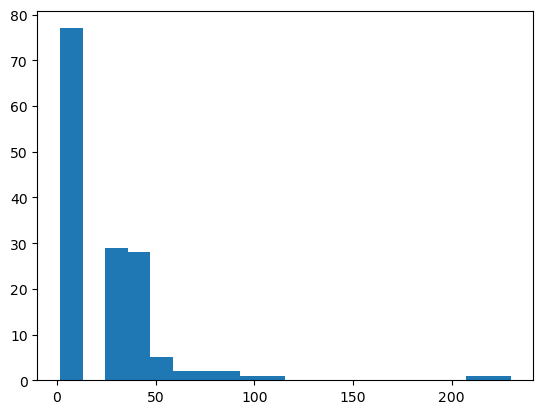

In [29]:
start = 1
stop = 150 #set the number of files you want to go through

statistics_metrics = []
stds = []

for i, filename in enumerate(os.listdir('heartbeat_data')):
    out = re.findall(r'\d+', filename)
    if int(out[0]) < start:
        continue
    if i == stop:
        break

    y_beats = filter_noise(filename)
    y_beat = filter_fetus(y_beats)
    
    # prominence = 1 means next peak can be found after follow points have a drop of at least 1
    # todo: plot single plot toether with average plot
    peaks = scipy.signal.find_peaks(y_beat, height=2, prominence=1)
    spike_times= peaks[0]
    spike_vals = peaks[1]['peak_heights']

    peak_distances = calc_peak_distances(spike_times)

    mean = np.mean(peak_distances, axis=0)
    
    std = np.std(peak_distances, axis=0)
    stds.append(std)

    statistics_metrics.append([i,mean,std,len(peak_distances)])
    
    # print(spike_times)
    # print("peak_dist", peak_distances)
    # print(filename) 
    # print("mean", mean)
    # print("std", std)
    # print("\n")

# Average S.D. = √ [(n1-1)s1^2 +  (n2-1)s2^2 + … +  (nk-1)sk^2] /  (n1+n2 + … + nk – k)

# nk: Sample size for kth group
# sk: Standard deviation for kth group
# k: Total number of groups

dividend = 0

for metric in statistics_metrics:
    sample_size = metric[3]
    std = metric[2]
    mean = metric[1]
    
    dividend += (sample_size-1)*(std**2)

divisor = 0

for metric in statistics_metrics:
    sample_size = metric[3]
    
    divisor += sample_size

divisor -= len(statistics_metrics)

mean_of_all_stds = np.sqrt(dividend/divisor)

print("mean of all stds", mean_of_all_stds)

plt.hist(stds,bins=20)
plt.show()

Most of the files have the standard diviation before 50. After 50 the number of files fall significantly off.

Therefore the threshhold is set right before 50.

Outliers
[17, 345.0, 230.02065124679567, 4]
[37, 159.3846153846154, 56.19682233219852, 13]
[46, 155.73333333333332, 57.11913475846387, 15]
[65, 170.0, 67.37581168342241, 12]
[69, 179.30769230769232, 50.03288859168939, 13]
[76, 278.0, 102.46755584086117, 5]
[89, 154.8, 73.42179512923938, 10]
[99, 142.41666666666666, 52.855870587433856, 12]
[102, 248.5, 108.89100054641797, 8]
[114, 187.66666666666666, 92.01026512780456, 6]
[121, 184.6153846153846, 86.99119182780116, 13]
[125, 181.27272727272728, 72.25219834225985, 11]
[134, 265.5, 213.7636935184894, 6]
[135, 147.63636363636363, 67.262407070805, 11]
[141, 145.5, 53.804429805236914, 12]


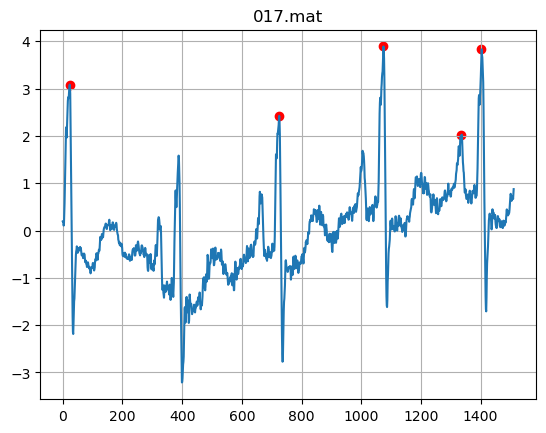

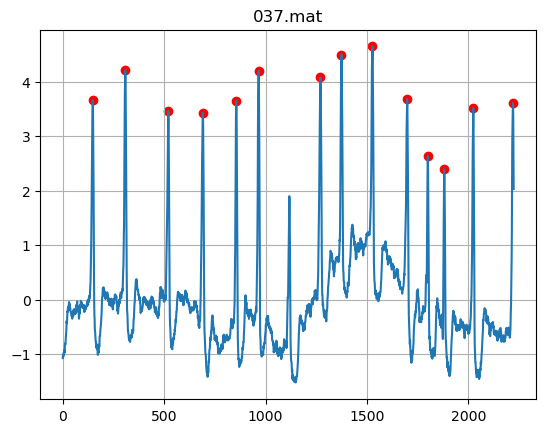

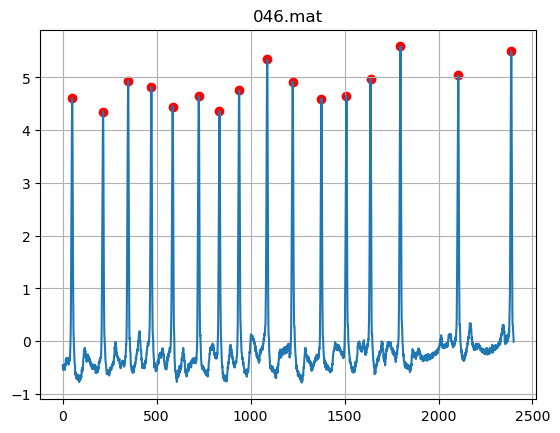

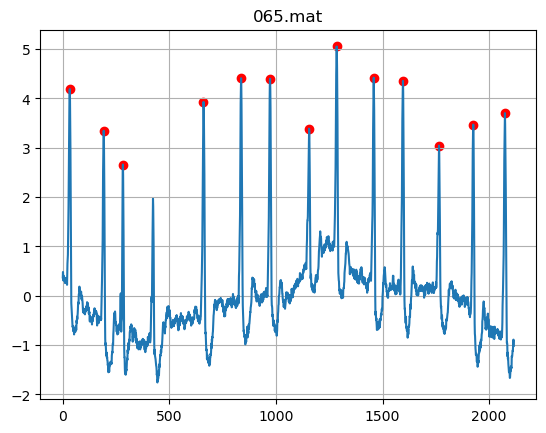

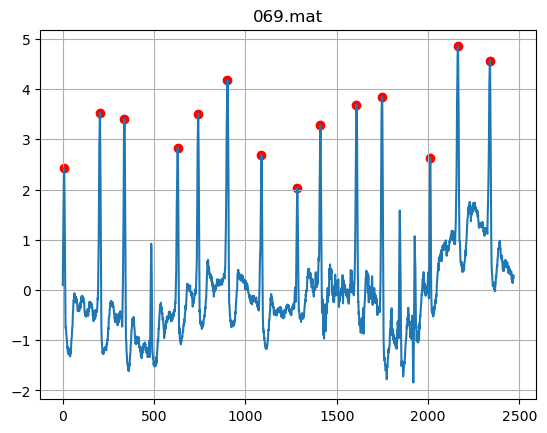

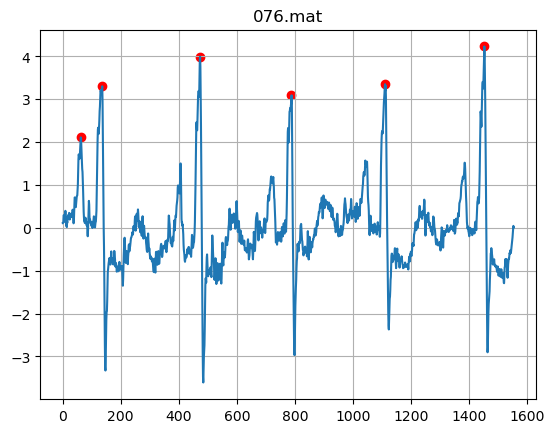

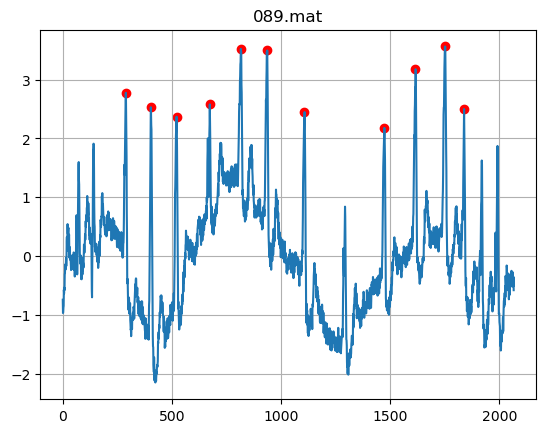

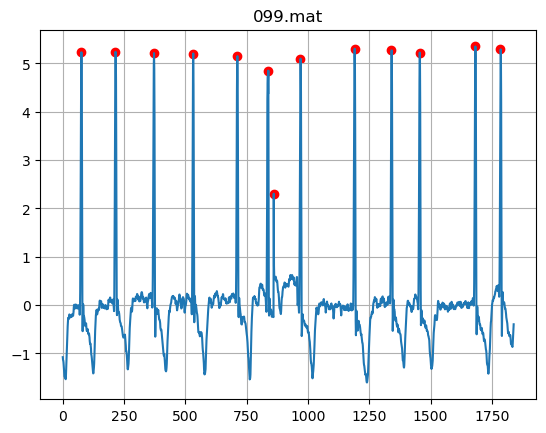

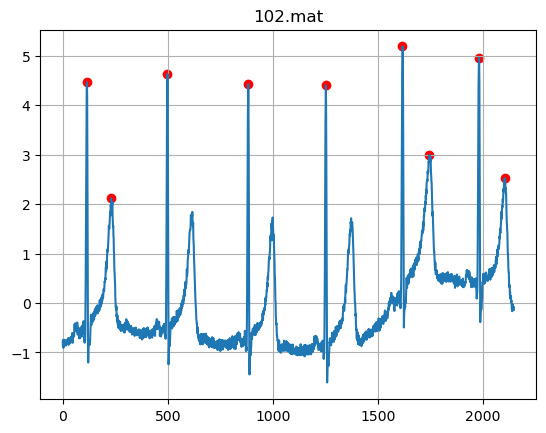

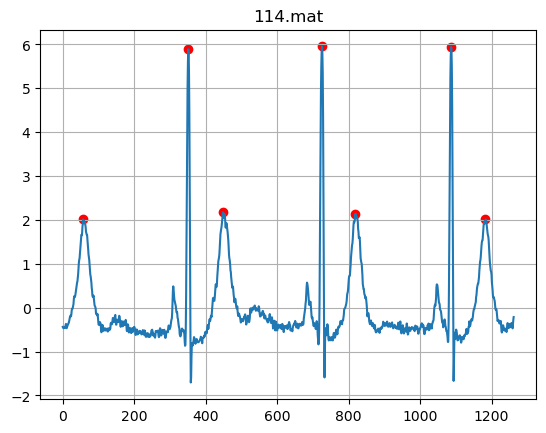

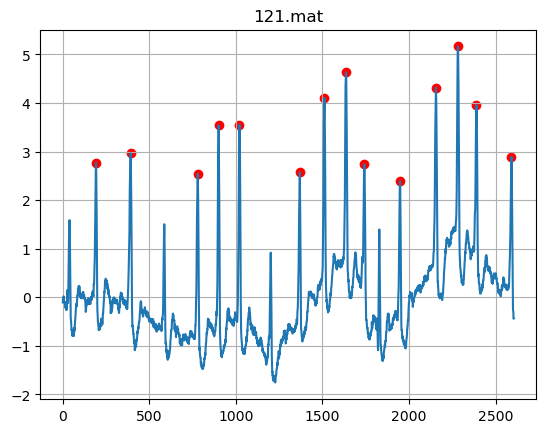

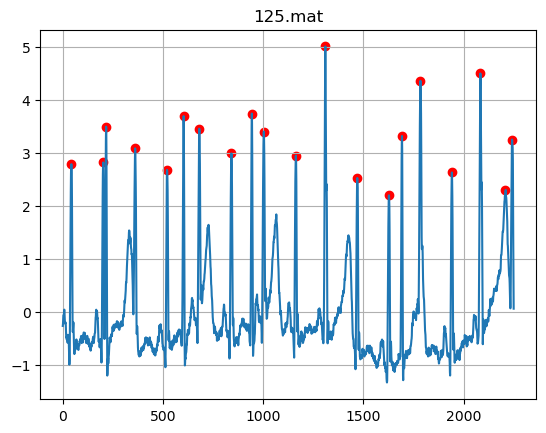

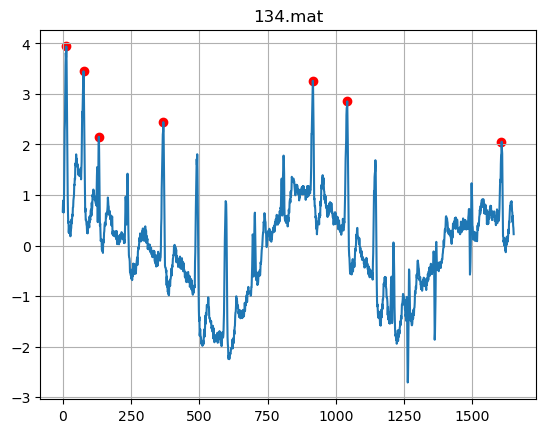

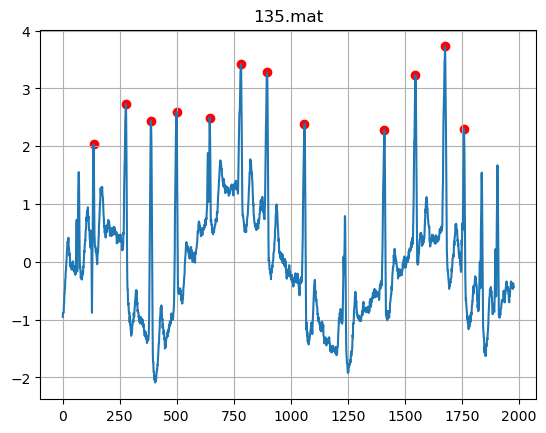

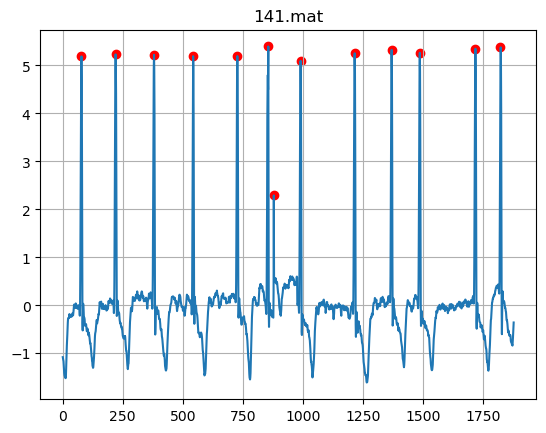

In [30]:
print("Outliers")
outliers = []
threshhold_for_std = 48
for metric in statistics_metrics:
    std = metric[2]

    if std > threshhold_for_std:
        outliers.append(metric)
        print(metric)
        show_single_plot_by_number(metric[0])